In [ ]:
import torchvision
import torch
import torchvision.transforms as transforms
import random
import numpy as np
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision import transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.nn as nn
import time
import os
import torch
import copy
import wandb
import json
import pandas as pd
import seaborn as sns




# Seeds for reproducibility
def set_seed(seed: int = 123):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
set_seed(123)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
""" PLOT SETTINGS """

plt.style.use("seaborn-v0_8")
plt.rcParams.update({
    "font.size": 18,            # base font size
    "axes.titlesize": 24,       # axis titles
    "axes.labelsize": 22,       # axis labels
    "xtick.labelsize": 18,      # X axis numbers
    "ytick.labelsize": 18,      # Y axis numbers
    "legend.fontsize": 20,      # legend text
    "lines.linewidth": 3.0      # line thickness
})


In [ ]:
""" CLASS TO CREATE THE HEAD with 100 CLASSES """
class DINOWithHead(nn.Module):
    def __init__(self, backbone, num_classes=100, p=None):
        super().__init__()
        self.backbone = backbone
        layers = []
        if p is not None:
            layers.append(nn.Dropout(p=p))
        layers.append(nn.Linear(384, num_classes))
        self.head = nn.Sequential(*layers)

    def forward(self, x):
        features = self.backbone(x)
        return self.head(features)

### Dataset Download and Transformations

In [ ]:
""" DATASET DOWNLOAD """

ROOT = './data'
BATCH_SIZE = 64
#BATCH_SIZE = 128
NUM_WORKERS = os.cpu_count()

tot_train_data = torchvision.datasets.CIFAR100(root=ROOT, train=True, download=True, transform=torchvision.transforms.ToTensor())
test_data = torchvision.datasets.CIFAR100(root=ROOT, train=False, download=True, transform=torchvision.transforms.ToTensor())

In [ ]:
""" SPLIT TOT_TRAININ in VALIDATION and TRAIN """

def split_dataset(tot_train_data, valid_ratio=0.8):
    """
    Splits the given dataset randomly into training and validation subsets.
    """
    train_size = int(valid_ratio * len(tot_train_data))
    val_size = len(tot_train_data) - train_size
    train_data, val_data = random_split(tot_train_data, [train_size, val_size])
    return train_data, val_data

train_data, val_data = split_dataset(tot_train_data, valid_ratio=0.8)

In [ ]:
""" DATA TRANSFORMATION """

def data_trasform(dataset, data_augmentation=False):   ### train_data or tot_train_data
    """
    Returns train and val/test transforms based on dataset stats.
    Dataset (for computing mean and std) can be either training only or combined train+validation.

    If data_augmentation=True, applies augmentation on training transforms, otherwise only resize and normalize.
    """

    # MEAN and VARIANCE (considering 3 channels)
    mean = torch.zeros(3)
    std = torch.zeros(3)
    nb_samples = 0

    for img, _ in dataset:
        img = img.view(3, -1)  # Flatten H*W in seconda dimensione
        mean += img.mean(1)
        std += img.std(1)
        nb_samples += 1

    mean /= nb_samples
    std /= nb_samples


    if data_augmentation:
        train_transforms = transforms.Compose([
            transforms.Resize(64, interpolation=transforms.InterpolationMode.BILINEAR),
            transforms.RandomCrop(64, padding=4),
            transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(degrees=15),
            transforms.RandAugment(num_ops=2, magnitude=9),
            transforms.ToTensor(),
            transforms.Normalize(mean=mean, std=std)
        ])
    else:
        train_transforms = transforms.Compose([
            transforms.Resize(64, interpolation=transforms.InterpolationMode.BILINEAR),
            transforms.ToTensor(),
            transforms.Normalize(mean=mean, std=std)
        ])

    ### NO DATA AUGMENTATION for val/test!
    val_test_transforms = transforms.Compose([
        transforms.Resize(64),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)   # Normalization using the training statistics
    ])


    return train_transforms, val_test_transforms

In [ ]:
""" DATA TRANSFORMATION and LOADERS """

### ===== For hyperparameter tuning considering train_data and val_data =====
train_transforms, val_test_transforms = data_trasform(train_data)

train_data.dataset.transform = train_transforms
val_data.dataset.transform = val_test_transforms

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader   = DataLoader(val_data,   batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)



### ===== For model testing considering tot_train_data and test_data =====
train_transforms, val_test_transforms = data_trasform(tot_train_data)

tot_train_data = torchvision.datasets.CIFAR100(root=ROOT, train=True, download=False, transform=train_transforms)
test_data = torchvision.datasets.CIFAR100(root=ROOT, train=False, download=False, transform=val_test_transforms)

tot_train_loader = DataLoader(tot_train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

### Test and Training Function

In [ ]:
""" TRAINING and TESTING """

def evaluate_model(model, data_loader, criterion):
    """
    The evaluate_model function computes the average loss and accuracy of a model on a dataset.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()

    total_loss = 0.0
    total_corrects = 0

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * inputs.size(0)
            total_corrects += torch.sum(preds == labels.data)

    avg_loss = total_loss / len(data_loader.dataset)
    avg_acc = total_corrects.double() / len(data_loader.dataset)
    return avg_loss, avg_acc.item()




def save_checkpoint(model, optimizer, scheduler, epoch, train_losses, train_accuracies,
                    val_test_losses, val_test_accuracies, best_acc, best_loss, best_model_wts, path):
    """
    The save_checkpoint function saves the model’s state, optimizer, scheduler, training/validation metrics,
    and best performance to a specified file path.
    """
    dir_name = os.path.dirname(path)
    if dir_name:
        os.makedirs(dir_name, exist_ok=True)
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict() if scheduler else None,
        'train_losses': train_losses,
        'train_accuracies': train_accuracies,
        'val_test_losses': val_test_losses,
        'val_test_accuracies': val_test_accuracies,
        'best_acc': best_acc,
        'best_loss': best_loss,
        'best_model_state_dict': best_model_wts
    }
    torch.save(checkpoint, path)




def init_checkpoint(model, optimizer, scheduler, path=None, device='cpu'):
    """
    Initialize a checkpoint. If path is None, create default checkpoint with empty/default values.
    If path is given and file exists, load it.
    """
    if path is None:  # default path
        os.makedirs("checkpoints", exist_ok=True)
        path = "checkpoints/latest.pth"
        print(f"Initializing new checkpoint at {path}")
        checkpoint = {   # save default empty checkpoint
            'epoch': 1,
            'best_acc': 0.0,
            'best_loss': 1e10,
            'train_losses': [],
            'train_accuracies': [],
            'val_test_losses': [],
            'val_test_accuracies': [],
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict() if scheduler else None,
            'best_model_state_dict': copy.deepcopy(model.state_dict())
        }
        torch.save(checkpoint, path)
        return 1, 0.0, 1e10, [], [], [], [], path, copy.deepcopy(model.state_dict())

    else: # load existing checkpoint
        if not os.path.isfile(path):
            raise FileNotFoundError(f"Checkpoint file {path} does not exist.")

        print(f"Loading checkpoint from {path}")
        checkpoint = torch.load(path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        if scheduler and checkpoint.get('scheduler_state_dict'):
            scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        best_model_wts = checkpoint.get('best_model_state_dict', copy.deepcopy(model.state_dict()))
        return (checkpoint['epoch'],
                checkpoint.get('best_acc', 0.0),
                checkpoint.get('best_loss', 1e10),
                checkpoint.get('train_losses', []),
                checkpoint.get('train_accuracies', []),
                checkpoint.get('val_test_losses', []),
                checkpoint.get('val_test_accuracies', []),
                path,
                best_model_wts )




def train_test_model(model, criterion, optimizer, scheduler, train_loader, val_test_loader,
                          num_epochs=10, checkpoint_path=None, checkpoints = True, verbose = 1):
                                        # If checkpoint_path = None, a path is created and training starts from scratch
                                        # If checkpoints = False, we don't save anything (used for the calibration part)
    """
    Trains a model with logging and evaluation, returning the best model and metrics.
    If a checkpoint path is provided, training will resume from the saved state in that file.
    """

    since = time.time()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    # === Checkpoints (Initialize if None, Load if it exists already) ===
    if checkpoints: # Training with checkpoints
        start_epoch, best_acc, best_loss, train_losses, train_accuracies, val_test_losses, val_test_accuracies, checkpoint_path, best_model_wts = \
            init_checkpoint(model, optimizer, scheduler, path=checkpoint_path, device=device)

    else: # No checkpoint
        start_epoch = 1
        best_acc = 0.0
        best_loss = 1e10
        train_losses, train_accuracies, val_test_losses, val_test_accuracies = [], [], [], []
        best_model_wts = copy.deepcopy(model.state_dict())

    # ===== Epoch loop =====
    for epoch in range(start_epoch, num_epochs+1):
        if checkpoints:
            if verbose:
                print(f'\nEpoch {epoch}/{num_epochs}')
                print('-' * 30)

        # ===== Training =====
        model.train()
        train_loss = 0.0
        train_corrects = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
            train_corrects += torch.sum(preds == labels.data)

        if scheduler:
            scheduler.step()

        epoch_train_loss = train_loss / len(train_loader.dataset)
        epoch_train_acc = train_corrects.double() / len(train_loader.dataset)

        if len(train_losses) >= epoch:     # Overwriting the current epoch's results if resuming from this position (if the current loop was never compelted)
            train_losses[epoch-1] = epoch_train_loss
            train_accuracies[epoch-1] = epoch_train_acc.item()
        else:
            train_losses.append(epoch_train_loss)
            train_accuracies.append(epoch_train_acc.item())

        if verbose == True:  # Print each round
            print(f'Train Loss: {epoch_train_loss:.4f} Train Acc: {epoch_train_acc:.4f}')


        # ===== Validation/Test =====
        epoch_val_test_loss, epoch_val_test_acc = evaluate_model(model, val_test_loader, criterion)

        if len(val_test_losses) >= epoch:    # Overwriting the current epoch's results if resuming from this position
            val_test_losses[epoch-1] = epoch_val_test_loss
            val_test_accuracies[epoch-1] = epoch_val_test_acc
        else:
            val_test_losses.append(epoch_val_test_loss)
            val_test_accuracies.append(epoch_val_test_acc)
        if verbose == True:
            print(f'Val/Test Loss: {epoch_val_test_loss:.4f}, Val/Test Acc: {epoch_val_test_acc:.4f}')

        if verbose == 'mid':
            if epoch == 1 or epoch % 5 == 0:   # Print occasionally
                print(f"Epoch {epoch}")
                print(f'Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f}')
                print(f'Val/Test Loss: {epoch_val_test_loss:.4f}, Val/Test Acc: {epoch_val_test_acc:.4f}')

        # ===== Update and Save the best model =====
        if epoch_val_test_acc > best_acc:
            best_acc = epoch_val_test_acc
            best_loss = epoch_val_test_loss
            best_model_wts = copy.deepcopy(model.state_dict())

        # ===== Save checkpoint =====
        if checkpoints:
            save_checkpoint(
                model, optimizer, scheduler,
                epoch + 1,
                train_losses, train_accuracies,
                val_test_losses, val_test_accuracies,
                best_acc, best_loss, best_model_wts,
                checkpoint_path
            )

    # Training completed
    time_elapsed = time.time() - since
    print(f'\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best Acc: {best_acc:.4f}, Best Loss: {best_loss:.4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)

    return model, train_losses, val_test_losses, train_accuracies, val_test_accuracies

### Functions for Masking & Fine Tuning

In [ ]:
""" FISHER SCORES COMPUTATION, MASKING, FINE-TUNING """


def compute_fisher_scores(model, data_loader, device='cuda', max_batches = None):
    """
    Compute diagonal Fisher Information scores.
    """
    model.eval()
    fisher_scores = {name: torch.zeros_like(param, device="cpu")      # Initialize a dictionary to store Fisher Information scores
                     for name, param in model.named_parameters() if param.requires_grad}

    for i, (inputs, labels) in enumerate(data_loader):
        if max_batches is not None and i >= max_batches:    # Stop if a maximum number of batches is reached
            break
        inputs, labels = inputs.to(device), labels.to(device)

        model.zero_grad()   # Reset gradients
        outputs = model(inputs)  # Forward pass through the model

        log_probs = F.log_softmax(outputs, dim=1)   # Compute log-probabilities for each class
        sampled_y = torch.multinomial(log_probs.exp(), num_samples=1).squeeze(-1)     # Sample a label from the predicted distribution for each input
        loss = F.nll_loss(log_probs, sampled_y)    # Compute Negative Log-Likelihood loss with the sampled labels

        loss.backward()  # Backpropagate to compute gradients
        for name, param in model.named_parameters():
            if param.grad is not None:
                fisher_scores[name] += (param.grad.detach().cpu() ** 2)   # Accumulate squared gradients into the Fisher scores

    # Normalize by dataset size
    dataset_size = len(data_loader.dataset)
    for name in fisher_scores.keys():
        fisher_scores[name] /= dataset_size

    return fisher_scores


def calibrate_mask_centralized(model, train_loader, device='cuda', R=5, final_sparsity=0.9,
                               lr=0.01, keep='least', do_train=True, max_batches=50, criterion=None, J=1):
    """
    Progressive pruning mask for a centralized model using Fisher scores.
    - R: number of calibration rounds
    - final_sparsity: target fraction of parameters to prune
    - keep: 'least', 'most', or 'random'
    - do_train: whether to perform mini-training at each step
    - max_batches: limit for Fisher computation
    Returns: final mask (dict {param_name: tensor})
    """
    if criterion is None:
        criterion = torch.nn.CrossEntropyLoss()

    # Initial mask: all ones for the trainable parameters
    mask = {name: torch.ones_like(param, device="cpu", dtype=torch.uint8)
            for name, param in model.named_parameters() if param.requires_grad}

    # List of trainable parameters
    trainable_params = [name for name, param in model.named_parameters() if param.requires_grad]

    for r in range(1, R + 1):   # Calibration rounds
        current_density = (1 - final_sparsity) ** (r / R)   # Represents the parameters to keep (mask==1)
        current_sparsity = 1 - current_density              # Represents the parameters to freeze (mask==0)
        print(f"[Mask Round {r}] Target Sparsity: {current_sparsity:.4f}")

        fisher_scores = compute_fisher_scores(model, train_loader, device=device, max_batches=max_batches)

        all_scores = torch.cat([score.view(-1) for score in fisher_scores.values()])   # Flatten all scores
        num_keep_global = int(len(all_scores) * current_density)
        num_keep_global = max(1, min(num_keep_global, len(all_scores)))       # Number of parameters to keep

        # topk returns the top k largest or smallest values in a tensor along with their indices.
        if keep == 'least':
            _, idx = torch.topk(all_scores, k=num_keep_global, largest=False)
        elif keep == 'most':
            _, idx = torch.topk(all_scores, k=num_keep_global, largest=True)
        elif keep == 'random':
            idx = torch.randperm(len(all_scores))[:num_keep_global]
        else:
            raise ValueError("keep must be 'least', 'most', or 'random'")

        global_keep = torch.zeros_like(all_scores, dtype=torch.bool)     # All 0
        global_keep[idx] = True                                          # True if to keep

        # Reconstruct the mask
        new_mask = {}    # To save the new updated mask
        start = 0
        for name, score in fisher_scores.items():
            numel = score.numel()     # Number tot. of elements

            # Selects the portion of the global boolean mask that corresponds to the current parameter
            keep_tensor = global_keep[start:start+numel].view_as(score)      # Return to the original form

            # Combining the newly selected elements (keep_tensor) with the previous mask, ensuring already frozen parameters remain inactive
            new_mask[name] = (keep_tensor.to(torch.uint8) * mask[name])
            start += numel  # Advances the start index for the next parameter

        mask = new_mask

        # Compute the total number of active parameters in the mask
        total_ones = sum(m.sum().item() for m in mask.values())
        total_params = sum(m.numel() for m in mask.values())
        perc_active = 100 * total_ones / total_params
        print(f"Total active parameters in the mask: {total_ones} / {total_params} ({perc_active:.2f}%)")

        if do_train: #Mini-training, using SparseSGD
            optimizer = SparseSGD(list(model.named_parameters()), lr=lr, mask=mask)
            model.train()

            J = 1 # If we want more then one training per calib.round J>1
            for _ in range(J):
                for inputs, labels in train_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    optimizer.zero_grad()
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    loss.backward()
                    optimizer.step()

    return mask


In [ ]:
from torch.optim.optimizer import Optimizer    # To inherit  for the custom SparseSGD

class SparseSGD(Optimizer):
    """
    Sparse SGD with momentum and parameter masks (gradients corresponding to zeros in the mask are ignored)
    """

    def __init__(self, named_params, lr=0.01, momentum=0, weight_decay=0, mask=None):
        """
        Args:
            params (iterable): model parameters to optimize
            mask (dict {param_name: tensor} or None): a binary mask for the parameters.
        """
        params = [p for _, p in named_params]
        defaults = dict(lr=lr, momentum=momentum, weight_decay=weight_decay)
        super().__init__(params, defaults)  # initialize base Optimizer

        # Initialize dictionary of parameter → mask mapping
        self.masks = {}
        if mask is not None:
            # Iterate over model parameters with their names
            for name, p in named_params:
                # If a mask exists for this parameter name
                if name in mask:
                    # Map the parameter object to its corresponding mask tensor (= explicitly attaching the right mask tensor to the right parameter)
                    self.masks[p] = mask[name].to(p.device)


    @torch.no_grad()    ### decorator: ensures that everything inside this function by default does not track gradients.
                        ### The function is manually updating model parameters, so we don’t want PyTorch to think these updates are part of the computational graph.
    def step(self, closure=None):
        """
        Performs a single optimization step.
        """
        if closure is not None:
            with torch.enable_grad():
                closure()

        for group in self.param_groups:
            for i, p in enumerate(group['params']):
                if p.grad is None:
                    continue  # skip parameters without gradients

                d_p = p.grad  # get gradient

                # Apply weight decay if specified
                if group['weight_decay'] != 0:
                    d_p = d_p.add(p, alpha=group['weight_decay'])

                # Momentum: maintain a buffer to smooth updates
                param_state = self.state[p]
                if 'momentum_buffer' not in param_state:
                    buf = param_state['momentum_buffer'] = d_p.clone()
                else:
                    buf = param_state['momentum_buffer']
                    buf.mul_(group['momentum']).add_(d_p)
                d_p = buf

                # Apply sparse mask if provided
                if self.masks is not None:
                    mask = self.masks.get(p, None)
                    if mask is not None:
                        d_p = d_p * mask

                # Update the parameter
                p.add_(d_p, alpha=-group['lr'])

# Tests

In [ ]:
# === MODEL with TRAINED HEAD ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dino_vits16 = torch.hub.load('facebookresearch/dino:main', 'dino_vits16')
dino_vits16.train()  # train mode for the backbone
dino_vits16 = dino_vits16.to(device)

        # Create the final model and log pre-trianed weights
model = DINOWithHead(dino_vits16, num_classes=100).to(device)
pretrained_weights="final_model_weights_BEST.pth"
checkpoint = torch.load(pretrained_weights, map_location=device)
model.load_state_dict(checkpoint)
model.head.eval() # Eval mode for the head

for name, param in model.named_parameters():
    if "head" in name: #or "norm" in name or "patch_embed" in name:   # head: already pre-trained
                                                                              # norm: small changes here can distort global statistics
                                                                              # patch_embed: initial representation => risk of degradating features
        param.requires_grad = False
    else:
        param.requires_grad = True

model = model.to(device)

Using cache found in C:\Users\vidag/.cache\torch\hub\facebookresearch_dino_main


### Calibration: start from the original model after calibration?

In [ ]:
set_seed(123)

# === PARAMETERS ===
SPARSITY = 0.7
N_EP = 10
T_MAX = N_EP
MOMENTUM = 0.9
LR = 5e-5
WEIGHT_DECAY = 5e-5
VERBOSE = True
C_ROUNDS = 2
KEEP = 'least'
MAX_B = 20

# === Load Baseline JSON (head-only training) ===
with open("results_central_BEST.json", 'r') as f:
    baseline_results = json.load(f)
print("Baseline imported successfully")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
results_all = {"baseline": baseline_results}

model_ft = copy.deepcopy(model).to(device)
model_ft.train()
for name, param in model_ft.named_parameters():
    if "head" in name:
        param.requires_grad = False
    else:
        param.requires_grad = True
model_calib = copy.deepcopy(model).to(device)
model_calib.train()
for name, param in model_calib.named_parameters():
    if "head" in name:
        param.requires_grad = False
    else:
        param.requires_grad = True


# === Loop over the two scenarios ===
for RESET_MODEL in [True, False]:
    print(f"\n=== Reset: {RESET_MODEL} ===")

    train_model = copy.deepcopy(model_ft).to(device)

    criterion = nn.CrossEntropyLoss()

    if RESET_MODEL == True:   # We use different models
        print("Calibration...")
        mask = calibrate_mask_centralized(
                model_calib, tot_train_loader, device,
                R=C_ROUNDS, final_sparsity=SPARSITY,
                lr=LR, keep=KEEP, do_train=True, max_batches=MAX_B
                )
        del model_calib
        torch.cuda.empty_cache()
    else: # We use always the same model
        print("Calibration...")
        mask = calibrate_mask_centralized(
                train_model, tot_train_loader, device,
                R=C_ROUNDS, final_sparsity=SPARSITY,
                lr=LR, keep=KEEP, do_train=True, max_batches=MAX_B
                )

    optimizer = SparseSGD(
        list(train_model.named_parameters()),
        lr=LR,
        momentum=MOMENTUM,
        weight_decay=WEIGHT_DECAY,
        mask=mask
    )
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=T_MAX)

    # === Training ===
    start_time = time.time()
    best_model, _, test_losses, _, test_accuracies = train_test_model(
        train_model,
        criterion,
        optimizer,
        scheduler,
        tot_train_loader,
        val_test_loader=test_loader,
        num_epochs=N_EP,
        checkpoint_path=None,
        verbose=VERBOSE
    )
    elapsed = time.time() - start_time
    print(f"Finished training in {elapsed:.2f}s")

    results_all[f"Reset{RESET_MODEL}_sparsity_{SPARSITY}"] = {
        "epochs": N_EP,
        "test_losses": test_losses,
        "test_accuracies": test_accuracies,
        "time_sec": elapsed
    }


# === Save results to JSON ===
with open("results_central_RESET_S0.7.json", 'w') as f:
    json.dump(results_all, f, indent=2)

Baseline imported successfully

=== Reset: True ===
Calibration...
[Mask Round 1] Target Sparsity: 0.4523
Totale parametri attivi nella mask: 11866772 / 21665664 (54.77%)
[Mask Round 2] Target Sparsity: 0.7000
Totale parametri attivi nella mask: 6468502 / 21665664 (29.86%)
Initializing new checkpoint at checkpoints/latest.pth

Epoch 1/10
------------------------------
Train Loss: 0.5707 Train Acc: 0.8343
Val/Test Loss: 1.0028 Acc: 0.7250

Epoch 2/10
------------------------------
Train Loss: 0.5212 Train Acc: 0.8485
Val/Test Loss: 0.9757 Acc: 0.7328

Epoch 3/10
------------------------------
Train Loss: 0.4910 Train Acc: 0.8574
Val/Test Loss: 0.9588 Acc: 0.7366

Epoch 4/10
------------------------------
Train Loss: 0.4673 Train Acc: 0.8652
Val/Test Loss: 0.9486 Acc: 0.7393

Epoch 5/10
------------------------------
Train Loss: 0.4484 Train Acc: 0.8711
Val/Test Loss: 0.9413 Acc: 0.7408

Epoch 6/10
------------------------------
Train Loss: 0.4338 Train Acc: 0.8753
Val/Test Loss: 0.9365 

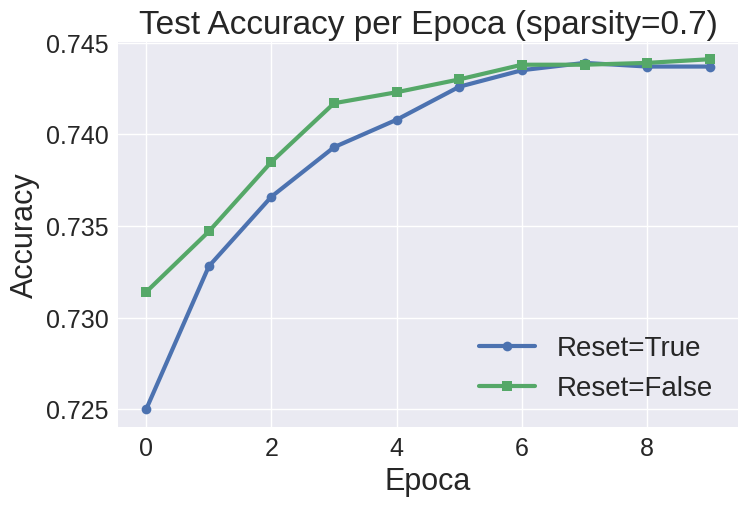

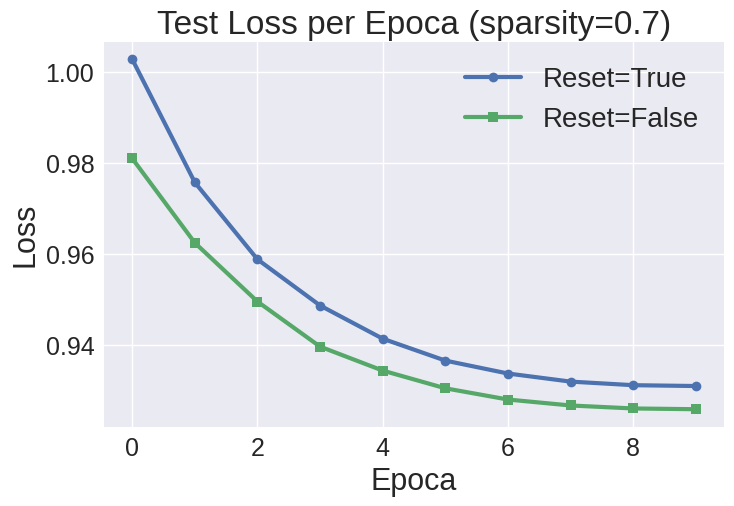

                Reset=True  Reset=False
final_accuracy    0.743700     0.744100
best_accuracy     0.743900     0.744100
final_loss        0.930902     0.925801
best_loss         0.930902     0.925801
time_sec        670.181623   670.211945


In [ ]:
# === load results Reset/Continue ===
with open("results_central_RESET_S0.7.json", "r") as f:
    results_all = json.load(f)

# Extract data Reset True / False
reset_losses = results_all.get("ResetTrue_sparsity_0.7", {}).get("test_losses", [])
reset_accs = results_all.get("ResetTrue_sparsity_0.7", {}).get("test_accuracies", [])
continue_losses = results_all.get("ResetFalse_sparsity_0.7", {}).get("test_losses", [])
continue_accs = results_all.get("ResetFalse_sparsity_0.7", {}).get("test_accuracies", [])

# === Accuracy Plot ===
plt.figure(figsize=(8,5))
plt.plot(reset_accs, label="Reset=True", marker="o")
plt.plot(continue_accs, label="Reset=False", marker="s")
plt.title("Test Accuracy per Epoca (sparsity=0.7)")
plt.xlabel("Epoca")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# === loss Plot ===
plt.figure(figsize=(8,5))
plt.plot(reset_losses, label="Reset=True", marker="o")
plt.plot(continue_losses, label="Reset=False", marker="s")
plt.title("Test Loss per Epoca (sparsity=0.7)")
plt.xlabel("Epoca")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

# === Summary ===
summary = {
    "Reset=True": {
        "final_accuracy": reset_accs[-1] if reset_accs else None,
        "best_accuracy": max(reset_accs) if reset_accs else None,
        "final_loss": reset_losses[-1] if reset_losses else None,
        "best_loss": min(reset_losses) if reset_losses else None,
        "time_sec": results_all.get("ResetTrue_sparsity_0.7", {}).get("time_sec", None)
    },
    "Reset=False": {
        "final_accuracy": continue_accs[-1] if continue_accs else None,
        "best_accuracy": max(continue_accs) if continue_accs else None,
        "final_loss": continue_losses[-1] if continue_losses else None,
        "best_loss": min(continue_losses) if continue_losses else None,
        "time_sec": results_all.get("ResetFalse_sparsity_0.7", {}).get("time_sec", None)
    }
}

df_summary = pd.DataFrame(summary)
print(df_summary)


It's not convenient to reset!

### Sparsity (1 calibration round)

In [ ]:
set_seed(123)

# === PARAMETERS ===
SPARSITY_LEVELS = [0.9, 0.6, 0.3, 0.0]
N_EP = 30
T_MAX = N_EP
MOMENTUM = 0.9
LR = 5e-5
WEIGHT_DECAY = 5e-5
VERBOSE = True
C_ROUNDS = 1
KEEP = 'least'   # or 'most' or 'random'
MAX_B=20


# === Load Baseline JSON (head-only training) ===
with open("results_central_BEST.json", 'r') as f:
    baseline_results = json.load(f)
print("Baseline imported successfully")


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
results_all = {"baseline": baseline_results}


# === Loop over sparsity levels ===
for sparsity in SPARSITY_LEVELS:
    print(f"\n=== Training with sparsity = {sparsity} ===")

    # Deepcopy the pre-loaded central model
    model_ft = copy.deepcopy(model).to(device)

    # Freeze the head (only backbone will be trained)
    for name, param in model_ft.named_parameters():
        if "head" in name:
            param.requires_grad = False
        else:
            param.requires_grad = True

    criterion = nn.CrossEntropyLoss()

    print("Calibration...")
    mask = None
    if sparsity > 0:
        print(f"Applying Fisher mask with sparsity {sparsity}")
        mask = calibrate_mask_centralized(model_ft, tot_train_loader, device, R=C_ROUNDS, final_sparsity=sparsity,
                                                      lr=LR, keep=KEEP, do_train=True, max_batches=MAX_B)
        optimizer = SparseSGD(
            list(model_ft.named_parameters()),
            lr=LR,
            momentum=MOMENTUM,
            weight_decay=WEIGHT_DECAY,
            mask=mask
        )
    else: # Full trianing (sparsity == 0.0)
        optimizer = torch.optim.SGD(model_ft.parameters(),
                        lr=LR,
                        momentum=MOMENTUM,
                        weight_decay=WEIGHT_DECAY)


    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=T_MAX)

    start_time = time.time()
    model_ft, _, test_losses, _, test_accuracies = train_test_model(
        model_ft,
        criterion,
        optimizer,
        scheduler,
        tot_train_loader,
        val_test_loader=test_loader,
        num_epochs=N_EP,
        checkpoint_path=None,
        verbose=VERBOSE
    )
    elapsed = time.time() - start_time
    print(f"Finished training for sparsity {sparsity} in {elapsed:.2f}s")

    results_all[f"sparsity_{sparsity}"] = {
        "epochs": N_EP,
        "test_losses": test_losses,
        "test_accuracies": test_accuracies,
        "time_sec": elapsed
    }

# === Save all results to JSON ===
with open("results_sparse_comparison_LEAST.json", 'w') as f:     # or 'MOST' or 'RANDOM'
    json.dump(results_all, f, indent=2)

Baseline imported successfully

=== Training with sparsity = 0.9 ===
Calibration...
Applying Fisher mask with sparsity 0.9
[Mask Round 1] Target Sparsity: 0.9000
Totale parametri attivi nella mask: 2166566 / 21665664 (10.00%)
Initializing new checkpoint at checkpoints/latest.pth

Epoch 1/30
------------------------------
Train Loss: 0.6019 Train Acc: 0.8284
Val/Test Loss: 1.0724 Acc: 0.7066

Epoch 2/30
------------------------------
Train Loss: 0.5865 Train Acc: 0.8321
Val/Test Loss: 1.0588 Acc: 0.7109

Epoch 3/30
------------------------------
Train Loss: 0.5764 Train Acc: 0.8340
Val/Test Loss: 1.0492 Acc: 0.7132

Epoch 4/30
------------------------------
Train Loss: 0.5686 Train Acc: 0.8361
Val/Test Loss: 1.0416 Acc: 0.7151

Epoch 5/30
------------------------------
Train Loss: 0.5621 Train Acc: 0.8375
Val/Test Loss: 1.0355 Acc: 0.7179

Epoch 6/30
------------------------------
Train Loss: 0.5564 Train Acc: 0.8388
Val/Test Loss: 1.0301 Acc: 0.7188

Epoch 7/30
------------------------

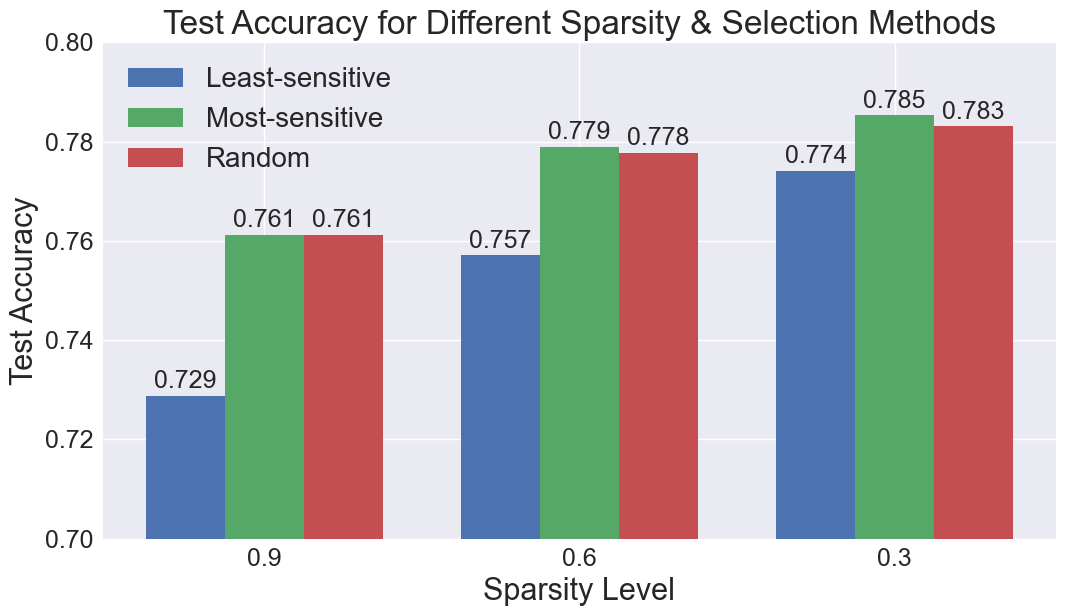

In [ ]:
# === Load results ===
with open("results_sparse_comparison_LEAST.json", 'r') as f:
    results_least = json.load(f)
with open("results_sparse_comparison_MOST.json", 'r') as f:
    results_most = json.load(f)
with open("results_sparse_comparison_RANDOM.json", 'r') as f:
    results_random = json.load(f)

sparsity_levels = [0.9, 0.6, 0.3]

# Extract final test accuracies for each sparsity
def final_acc(results, sparsity_levels):
    accs = []
    for s in sparsity_levels:
        key = f"sparsity_{s}"
        accs.append(results[key]["test_accuracies"][-1])  # last epoch
    return accs

acc_least = final_acc(results_least, sparsity_levels)
acc_most = final_acc(results_most, sparsity_levels)
acc_random = final_acc(results_random, sparsity_levels)

# === Bar plot ===
x = np.arange(len(sparsity_levels))  # label locations
width = 0.25  # width of each bar

fig, ax = plt.subplots(figsize=(11,6.5))

rects1 = ax.bar(x - width, acc_least, width, label='Least-sensitive')
rects2 = ax.bar(x, acc_most, width, label='Most-sensitive')
rects3 = ax.bar(x + width, acc_random, width, label='Random')

# Labels
ax.set_ylabel('Test Accuracy')
ax.set_xlabel('Sparsity Level')
ax.set_title('Test Accuracy for Different Sparsity & Selection Methods')
ax.set_xticks(x)
ax.set_xticklabels([str(s) for s in sparsity_levels])
ax.legend()
ax.set_ylim(0.7, 0.8)

# Add value labels on top
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(rect.get_x() + rect.get_width()/2, height),
                    xytext=(0,2),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

plt.tight_layout()
plt.show()


In [ ]:
sparsity_levels = [0.0, 0.3, 0.6, 0.9]  # include 0.0 = no sparsity
methods = {
    "Least-sensitive": results_least,
    "Most-sensitive": results_most,
    "Random": results_random
}

summary_data = []

for method_name, results in methods.items():
    for s in sparsity_levels:
        key = f"sparsity_{s}"
        if key not in results:   # skip if this sparsity is not in the results
            continue
        res = results[key]
        summary_data.append({
            "Method": method_name,
            "Sparsity": s,
            "Best_Accuracy": max(res["test_accuracies"]),
            "Final_Accuracy": res["test_accuracies"][-1],
            "Best_Loss": min(res["test_losses"]),
            "Final_Loss": res["test_losses"][-1],
            "Training_Time_sec": round(res.get("time_sec", 0.0), 2)
        })

df_summary = pd.DataFrame(summary_data)
df_summary = df_summary.sort_values(["Method", "Sparsity"], ascending=[True, False])

print("=== Summary Table ===")
print(df_summary.to_string(index=False))


### Calibration, Fixed Sparsity

In [ ]:
set_seed(123)

# === PARAMETERS ===
SPARSITY = 0.5
C_ROUNDS_LIST = [1, 2, 5]
N_EP = 20
T_MAX = N_EP
MOMENTUM = 0.9
LR = 5e-5
WEIGHT_DECAY = 5e-5
VERBOSE = True
KEEP = 'least'

MAX_B=20

# === Load Baseline JSON (head-only training) ===
with open("results_central_BEST.json", 'r') as f:
    baseline_results = json.load(f)
print("Baseline imported successfully")


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
results_all = {"baseline": baseline_results}

for rounds in C_ROUNDS_LIST:
    print(f"\n=== Training with calibration rounds = {rounds} ===")

    # Deepcopy of the base model
    model_ft = copy.deepcopy(model).to(device)
    for name, param in model_ft.named_parameters():
        param.requires_grad = ("head" not in name)

    criterion = nn.CrossEntropyLoss()

    # Calibration
    print("Calibration...")
    mask = calibrate_mask_centralized(
        model_ft, tot_train_loader, device,
        R=rounds, final_sparsity=SPARSITY,
        lr=LR, keep=KEEP, do_train=True, max_batches=MAX_B
    )

    optimizer = SparseSGD(
        list(model_ft.named_parameters()),
        lr=LR,
        momentum=MOMENTUM,
        weight_decay=WEIGHT_DECAY,
        mask=mask
    )
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=T_MAX)

    # Training
    start_time = time.time()
    model_ft, _, test_losses, _, test_accuracies = train_test_model(
        model_ft,
        criterion,
        optimizer,
        scheduler,
        tot_train_loader,
        val_test_loader=test_loader,
        num_epochs=N_EP,
        checkpoint_path=None,
        verbose=VERBOSE
    )
    elapsed = time.time() - start_time
    print(f"Finished training for rounds={rounds} in {elapsed:.2f}s")

    results_all[f"calibration_{rounds}"] = {
        "epochs": N_EP,
        "test_losses": test_losses,
        "test_accuracies": test_accuracies,
        "time_sec": elapsed
    }

# Saving results
with open("results_sparse_comparison_ROUNDS.json", 'w') as f:
    json.dump(results_all, f, indent=2)


Baseline imported successfully

=== Training with calibration rounds = 1 ===
Calibration...
[Mask Round 1] Target Sparsity: 0.5000
Totale parametri attivi nella mask: 10832832 / 21665664 (50.00%)
Initializing new checkpoint at checkpoints/latest.pth

Epoch 1/20
------------------------------
Train Loss: 0.5304 Train Acc: 0.8432
Val/Test Loss: 0.9298 Acc: 0.7436

Epoch 2/20
------------------------------
Train Loss: 0.4370 Train Acc: 0.8729
Val/Test Loss: 0.8991 Acc: 0.7514

Epoch 3/20
------------------------------
Train Loss: 0.3692 Train Acc: 0.8958
Val/Test Loss: 0.8882 Acc: 0.7545

Epoch 4/20
------------------------------
Train Loss: 0.3134 Train Acc: 0.9162
Val/Test Loss: 0.8793 Acc: 0.7565

Epoch 5/20
------------------------------
Train Loss: 0.2663 Train Acc: 0.9345
Val/Test Loss: 0.8791 Acc: 0.7575

Epoch 6/20
------------------------------
Train Loss: 0.2276 Train Acc: 0.9494
Val/Test Loss: 0.8768 Acc: 0.7588

Epoch 7/20
------------------------------
Train Loss: 0.1954 Trai

Keys in results_all: ['baseline', 'calibration_1', 'calibration_2', 'calibration_5']


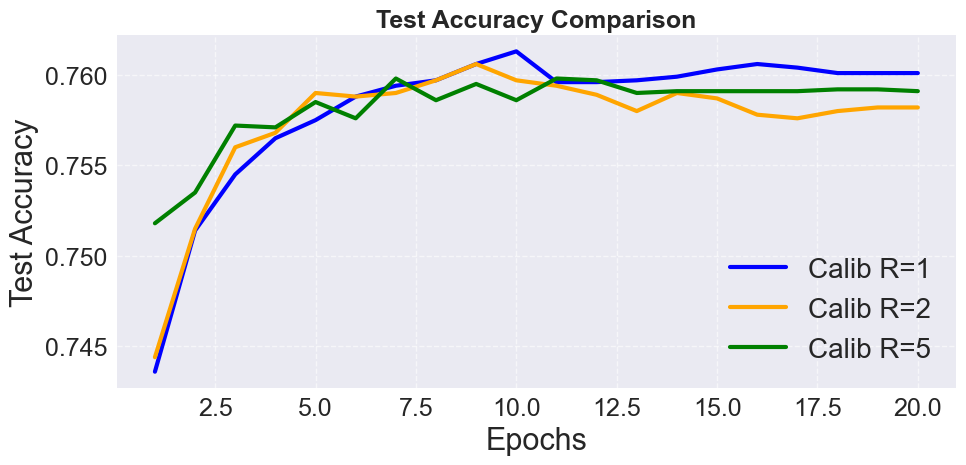

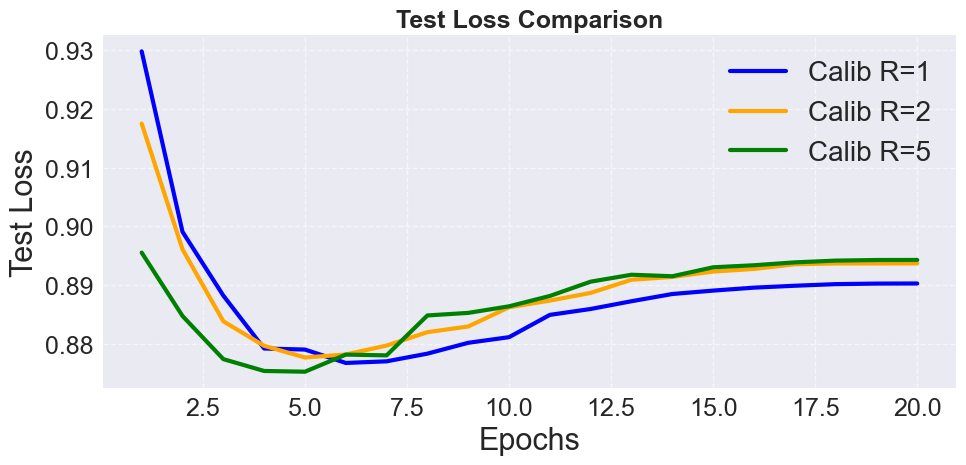

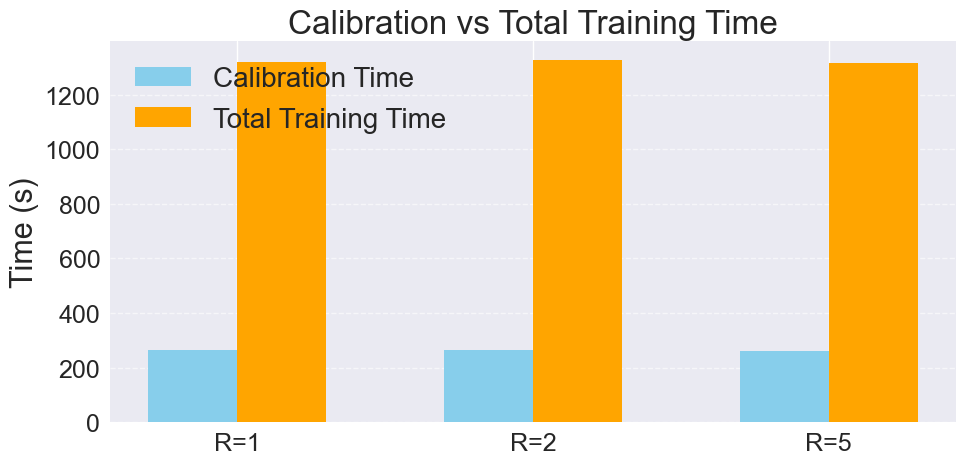


=== SUMMARY ===
   Config  Final Accuracy  Best Accuracy  Final Loss  Best Loss  Total Time (s)  Calibration Time (s)
Head-only          0.6967         0.6972    1.101205   1.095618         1213.84                  0.00
Calib R=1          0.7601         0.7613    0.890306   0.876796         1318.04                263.61
Calib R=2          0.7582         0.7606    0.893720   0.877725         1327.71                265.54
Calib R=5          0.7591         0.7598    0.894310   0.875306         1313.92                262.78


In [ ]:
# === Load saved results ===
with open("results_sparse_comparison_ROUNDS_OLD.json", "r") as f:
    results_all = json.load(f)

C_ROUNDS_LIST = [1, 2, 5]


print("Keys in results_all:", list(results_all.keys()))

# Plot COnfiguration
configs = [f"Calib R={r}" for r in C_ROUNDS_LIST]
colors = ['blue', 'orange', 'green', 'red', 'purple']

# === PLot Test Accuracy ===
plt.figure(figsize=(10,5))
plt.title("Test Accuracy Comparison", fontsize=18, fontweight="bold")
plt.xlabel("Epochs")
plt.ylabel("Test Accuracy")
plt.grid(True, linestyle="--", alpha=0.6)

# Plot calib rounds (without baseline)
for i, rounds in enumerate(C_ROUNDS_LIST):
    acc = results_all[f"calibration_{rounds}"]["test_accuracies"]
    plt.plot(range(1, N_EP+1), acc, label=f"Calib R={rounds}", color=colors[i])

plt.legend()
plt.tight_layout()
plt.show()

# === Plot Test Loss ===
plt.figure(figsize=(10,5))
plt.title("Test Loss Comparison", fontsize=18, fontweight="bold")
plt.xlabel("Epochs")
plt.ylabel("Test Loss")
plt.grid(True, linestyle="--", alpha=0.6)

# Plot calib rounds (without baseline)
for i, rounds in enumerate(C_ROUNDS_LIST):
    loss = results_all[f"calibration_{rounds}"]["test_losses"]
    plt.plot(range(1, N_EP+1), loss, label=f"Calib R={rounds}", color=colors[i])

plt.legend()
plt.tight_layout()
plt.show()

# === Bar plot: Calibration Time vs Training tot. ===
calibration_times = []
training_times = []

for rounds in C_ROUNDS_LIST:
    res = results_all[f"calibration_{rounds}"]
    training_times.append(res['time_sec'])
    calibration_times.append(res.get('calibration_time_sec', res['time_sec']*0.2))

plt.figure(figsize=(10,5))
x = range(len(C_ROUNDS_LIST))
plt.bar([i-0.15 for i in x], calibration_times, width=0.3, label="Calibration Time", color='skyblue')
plt.bar([i+0.15 for i in x], training_times, width=0.3, label="Total Training Time", color='orange')
plt.xticks(x, [f"R={r}" for r in C_ROUNDS_LIST])
plt.ylabel("Time (s)")
plt.title("Calibration vs Total Training Time")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6, axis="y")
plt.tight_layout()
plt.show()

# === Summary Table ===
summary_data = []

# Baseline
summary_data.append({
    "Config": "Head-only",
    "Final Accuracy": baseline_results["test_accuracies"][-1],
    "Best Accuracy": max(baseline_results["test_accuracies"]),
    "Final Loss": baseline_results["test_losses"][-1],
    "Best Loss": min(baseline_results["test_losses"]),
    "Total Time (s)": baseline_results.get("time_sec", None),
    "Calibration Time (s)": 0.0
})

# Calibration configs
for rounds in C_ROUNDS_LIST:
    res = results_all[f"calibration_{rounds}"]
    summary_data.append({
        "Config": f"Calib R={rounds}",
        "Final Accuracy": res["test_accuracies"][-1],
        "Best Accuracy": max(res["test_accuracies"]),
        "Final Loss": res["test_losses"][-1],
        "Best Loss": min(res["test_losses"]),
        "Total Time (s)": round(res["time_sec"], 2),
        "Calibration Time (s)": round(res.get("calibration_time_sec", res["time_sec"]*0.2), 2)
    })

df_summary = pd.DataFrame(summary_data)
print("\n=== SUMMARY ===")
print(df_summary.to_string(index=False))



In [ ]:
set_seed(123)

# === PARAMETERS ===
SPARSITY = 0.5
C_ROUNDS_LIST = [2, 5]   # Calibration
N_EP = 20
T_MAX = N_EP
MOMENTUM = 0.9
LR = 5e-5
WEIGHT_DECAY = 5e-5
VERBOSE = True
KEEP = 'least'
MAX_B = 20

# === Load Baseline JSON (head-only training) ===
with open("results_central_BEST.json", 'r') as f:
    baseline_results = json.load(f)
print("Baseline imported successfully")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
results_all = {"baseline": baseline_results}

# === Loop over calibration rounds and do_train flag ===
for rounds in C_ROUNDS_LIST:
    for do_train_flag in [True, False]:
        print(f"\n=== Training with calibration rounds = {rounds}, do_train={do_train_flag} ===")

        # Deepcopy of the base model
        model_ft = copy.deepcopy(model).to(device)
        for name, param in model_ft.named_parameters():
            param.requires_grad = ("head" not in name)

        criterion = nn.CrossEntropyLoss()

        # Calibration
        print("Calibration...")
        mask = calibrate_mask_centralized(
            model_ft, tot_train_loader, device,
            R=rounds, final_sparsity=SPARSITY,
            lr=LR, keep=KEEP, do_train=do_train_flag, max_batches=MAX_B
        )

        optimizer = SparseSGD(
            list(model_ft.named_parameters()),
            lr=LR,
            momentum=MOMENTUM,
            weight_decay=WEIGHT_DECAY,
            mask=mask
        )
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=T_MAX)

        # Training
        start_time = time.time()
        model_ft, _, test_losses, _, test_accuracies = train_test_model(
            model_ft,
            criterion,
            optimizer,
            scheduler,
            tot_train_loader,
            val_test_loader=test_loader,
            num_epochs=N_EP,
            checkpoint_path=None,
            verbose=VERBOSE
        )
        elapsed = time.time() - start_time
        print(f"Finished training for rounds={rounds}, do_train={do_train_flag} in {elapsed:.2f}s")

        results_all[f"calibration_{rounds}_train_{do_train_flag}"] = {
            "epochs": N_EP,
            "test_losses": test_losses,
            "test_accuracies": test_accuracies,
            "time_sec": elapsed,
            "do_train": do_train_flag
        }

# Saving Results
with open("results_sparse_comparison_ROUNDS.json", 'w') as f:
    json.dump(results_all, f, indent=2)


Baseline imported successfully

=== Training with calibration rounds = 2, do_train=True ===
Calibration...
[Mask Round 1] Target Sparsity: 0.2929
Total active parameters in the mask: 15319937 / 21665664 (70.71%)
[Mask Round 2] Target Sparsity: 0.5000
Total active parameters in the mask: 10588593 / 21665664 (48.87%)
Initializing new checkpoint at checkpoints/latest.pth

Epoch 1/20
------------------------------
Train Loss: 1.6241 Train Acc: 0.5551
Val/Test Loss: 1.6898, Val/Test Acc: 0.5370

Epoch 2/20
------------------------------
Train Loss: 1.4260 Train Acc: 0.6043
Val/Test Loss: 1.5623, Val/Test Acc: 0.5659

Epoch 3/20
------------------------------
Train Loss: 1.2811 Train Acc: 0.6377
Val/Test Loss: 1.4688, Val/Test Acc: 0.5899

Epoch 4/20
------------------------------
Train Loss: 1.1577 Train Acc: 0.6701
Val/Test Loss: 1.3944, Val/Test Acc: 0.6121

Epoch 5/20
------------------------------
Train Loss: 1.0488 Train Acc: 0.6988
Val/Test Loss: 1.3348, Val/Test Acc: 0.6271

Epoch 6/


=== SUMMARY ===
                   Config  Rounds  Do_Train  Final_Accuracy  Best_Accuracy  Final_Loss  Best_Loss  Total_Time (s)
                 baseline       0     False          0.6967         0.6972    1.101205   1.095618         1213.84
calibration_2_train_False       2     False          0.6713         0.6719    1.282411   1.200471         2576.34
 calibration_2_train_True       2      True          0.6658         0.6660    1.254426   1.223374         2641.75
calibration_5_train_False       5     False          0.6669         0.6674    1.271387   1.212204         2631.34
 calibration_5_train_True       5      True          0.6605         0.6616    1.276787   1.246782         2660.82


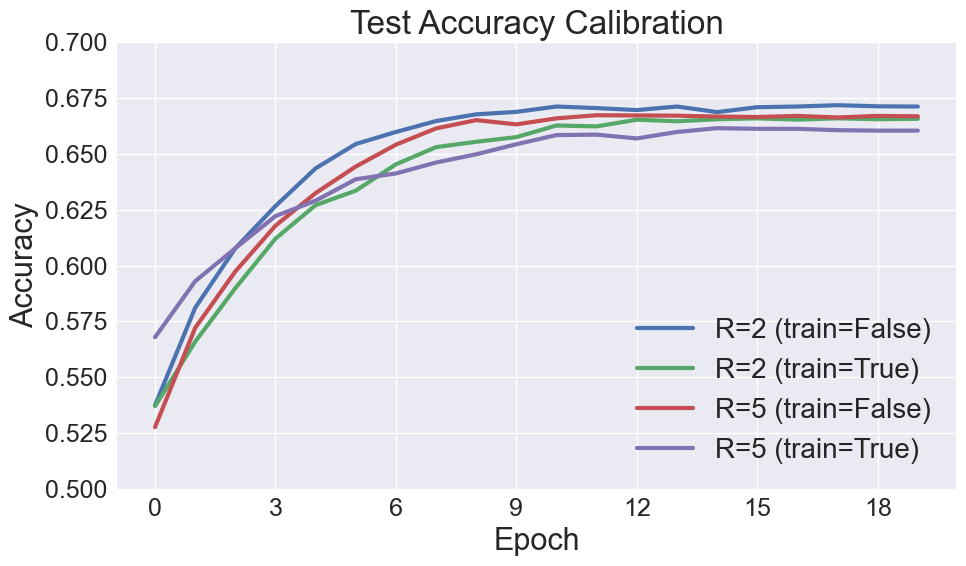

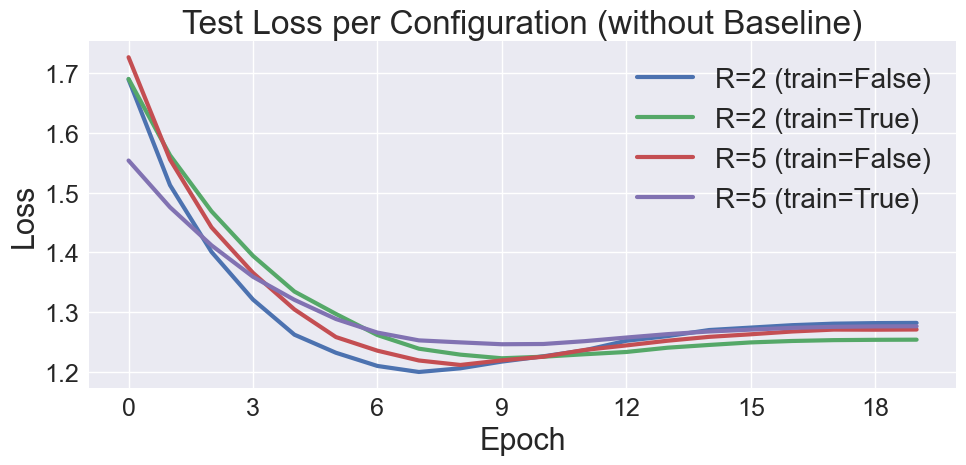

In [ ]:
import matplotlib.ticker as mticker

# === Load results ===
with open("results_sparse_comparison_ROUNDS.json", 'r') as f:
    results_all = json.load(f)

# === Build summary table ===
summary_data = []

for key, res in results_all.items():
    parts = key.split('_')
    # Identify if this is baseline
    is_baseline = key == "baseline"
    rounds = int(parts[1]) if not is_baseline else 0
    do_train_flag = res.get("do_train", False) if not is_baseline else False

    summary_data.append({
        "Config": key,
        "Rounds": rounds,
        "Do_Train": do_train_flag,
        "Final_Accuracy": res["test_accuracies"][-1],
        "Best_Accuracy": max(res["test_accuracies"]),
        "Final_Loss": res["test_losses"][-1],
        "Best_Loss": min(res["test_losses"]),
        "Total_Time (s)": round(res["time_sec"], 2),
        "All_Accuracies": res["test_accuracies"],
        "All_Losses": res["test_losses"]
    })

df_summary = pd.DataFrame(summary_data).sort_values(["Rounds", "Do_Train"])

# === Print summary ===
print("\n=== SUMMARY ===")
print(df_summary[['Config','Rounds','Do_Train','Final_Accuracy','Best_Accuracy','Final_Loss','Best_Loss','Total_Time (s)']].to_string(index=False))

# === Define custom labels for plotting ===
custom_labels = {
    "baseline": "Head-only Baseline",
    "calibration_2_train_True": "R=2 (train=True)",
    "calibration_2_train_False": "R=2 (train=False)",
    "calibration_5_train_True": "R=5 (train=True)",
    "calibration_5_train_False": "R=5 (train=False)"
}
# === Filter out baseline ===
df_plot = df_summary[df_summary['Config'] != "baseline"]

# === Plot Accuracy curves with integer x-axis ===
plt.figure(figsize=(10,6))
for _, row in df_plot.iterrows():
    label = custom_labels.get(row['Config'], row['Config'])
    plt.plot(row['All_Accuracies'], label=label)
plt.title("Test Accuracy Calibration")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc='lower right')
plt.ylim(0.5, 0.7)
plt.grid(True)
plt.gca().xaxis.set_major_locator(mticker.MaxNLocator(integer=True))  # force integer x ticks
plt.tight_layout()
plt.show()

# === Plot Loss curves with integer x-axis ===
plt.figure(figsize=(10,5))
for _, row in df_plot.iterrows():
    label = custom_labels.get(row['Config'], row['Config'])
    plt.plot(row['All_Losses'], label=label, marker='x')
plt.title("Test Loss per Configuration (without Baseline)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc='upper right')
plt.grid(True)
plt.gca().xaxis.set_major_locator(mticker.MaxNLocator(integer=True))  # force integer x ticks
plt.tight_layout()
plt.show()



### Selective masking (Masking only a portion of layers)

In [ ]:
set_seed(123)

SPARSITY = 0.5
C_ROUNDS = 2
N_EP = 40
T_MAX = N_EP
MOMENTUM = 0.9
LR = 5e-5
WEIGHT_DECAY = 5e-5
VERBOSE = True
KEEP = 'least'
MAX_B = 20

# Load baseline
with open("results_central_BEST.json", 'r') as f:
    baseline_results = json.load(f)
print("Baseline imported successfully")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
results_all = {"baseline": baseline_results}

# === Scenarios ===
scenarios = ["standard_mask", "selective_mask"]

for scenario in scenarios:
    print(f"\n=== Training scenario: {scenario} ===")


    model_ft = copy.deepcopy(model).to(device)

    # Freezing head
    for name, param in model_ft.named_parameters():
        param.requires_grad = ("head" not in name)

    # Type of scenario: selective, freeze embedding e final projection
    if scenario == "selective_mask":
        for name, param in model_ft.named_parameters():
            if ("embedding" in name.lower()) or ("proj" in name.lower()):
                param.requires_grad = False

    criterion = nn.CrossEntropyLoss()

    # Calibration
    print("Calibration...")
    mask = calibrate_mask_centralized(
        model_ft, tot_train_loader, device,
        R=C_ROUNDS, final_sparsity=SPARSITY,
        lr=LR, keep=KEEP, do_train=True, max_batches=MAX_B
    )
    # === Counting how many parameters are active in the mask ===
    total_params = 0
    active_params = 0
    for layer_name, layer_mask in mask.items():
        total_params += layer_mask.numel()
        active_params += layer_mask.sum().item()

    print(f"Scenario: {scenario}")
    print(f"Parametri totali: {total_params}, attivi (1) nel mask: {active_params}, sparsity effettiva: {1 - active_params/total_params:.3f}")



    optimizer = SparseSGD(
        list(model_ft.named_parameters()),
        lr=LR,
        momentum=MOMENTUM,
        weight_decay=WEIGHT_DECAY,
        mask=mask
    )
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=T_MAX)

    # Training
    start_time = time.time()
    model_ft, _, test_losses, _, test_accuracies = train_test_model(
        model_ft,
        criterion,
        optimizer,
        scheduler,
        tot_train_loader,
        val_test_loader=test_loader,
        num_epochs=N_EP,
        checkpoint_path=None,
        verbose=VERBOSE
    )
    elapsed = time.time() - start_time
    print(f"Finished training for scenario={scenario} in {elapsed:.2f}s")

    results_all[f"{scenario}_S{SPARSITY}"] = {
        "epochs": N_EP,
        "test_losses": test_losses,
        "test_accuracies": test_accuracies,
        "time_sec": elapsed
    }


with open("results_sparse_comparison_SELECTIVE.json", 'w') as f:
    json.dump(results_all, f, indent=2)


Baseline imported successfully

=== Training scenario: standard_mask ===
Calibration...
[Mask Round 1] Target Sparsity: 0.2929
Totale parametri attivi nella mask: 15319937 / 21665664 (70.71%)
[Mask Round 2] Target Sparsity: 0.5000
Totale parametri attivi nella mask: 10749796 / 21665664 (49.62%)
Scenario: standard_mask
Parametri totali: 21665664, attivi (1) nel mask: 10749796, sparsity effettiva: 0.504
Initializing new checkpoint at checkpoints/latest.pth

Epoch 1/40
------------------------------
Train Loss: 0.4995 Train Acc: 0.8529
Val/Test Loss: 0.9169 Acc: 0.7465

Epoch 2/40
------------------------------
Train Loss: 0.4201 Train Acc: 0.8774
Val/Test Loss: 0.8984 Acc: 0.7513

Epoch 3/40
------------------------------
Train Loss: 0.3582 Train Acc: 0.8996
Val/Test Loss: 0.8853 Acc: 0.7536

Epoch 4/40
------------------------------
Train Loss: 0.3051 Train Acc: 0.9194
Val/Test Loss: 0.8826 Acc: 0.7570

Epoch 5/40
------------------------------
Train Loss: 0.2597 Train Acc: 0.9370
Val/T

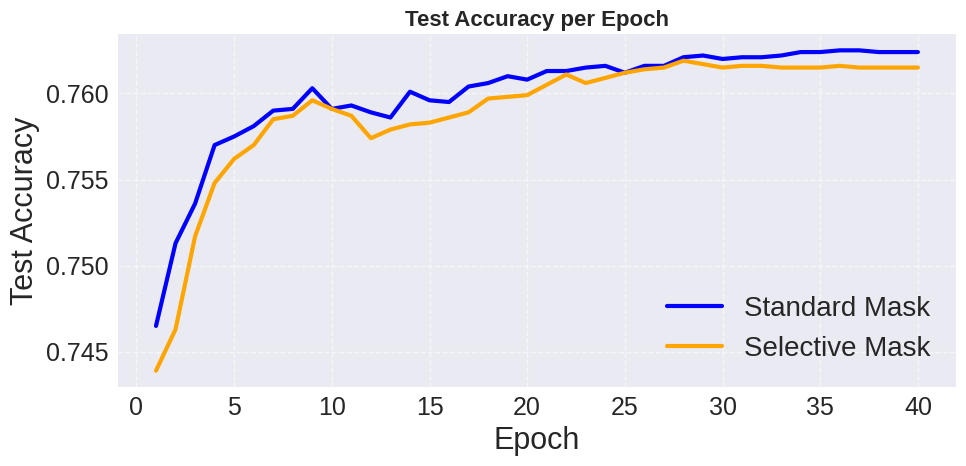

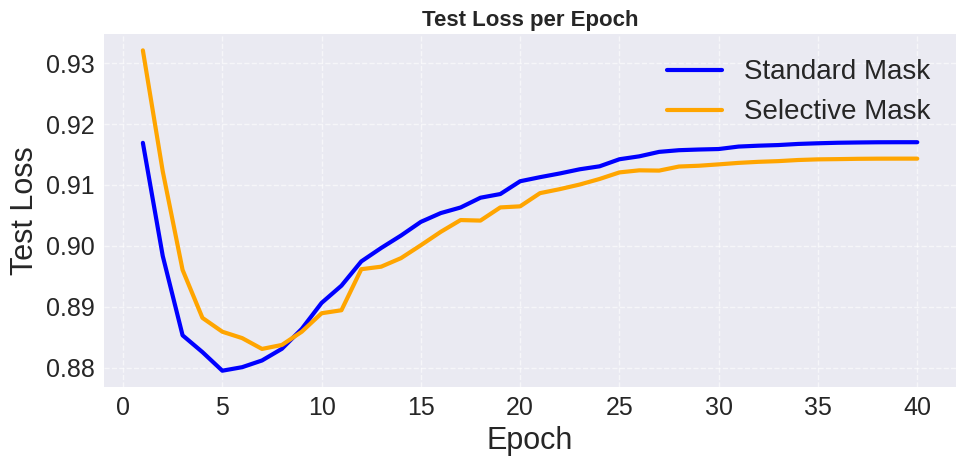


=== SUMMARY (no baseline) ===
      Scenario  Best Accuracy  Final Accuracy  Best Loss  Final Loss  Training Time (s)
 Standard Mask         0.7625          0.7624   0.879508    0.917024            2612.27
Selective Mask         0.7619          0.7615   0.883084    0.914329            2567.03


In [ ]:
# === Load results ===
with open("results_sparse_comparison_SELECTIVE.json", 'r') as f:
    results_all = json.load(f)

# scenarios
scenarios = ['standard_mask_S0.5', 'selective_mask_S0.5']
colors = ['blue', 'orange']

# === Plot Test Accuracy ===
plt.figure(figsize=(10,5))
plt.title("Test Accuracy per Epoch", fontsize=16, fontweight='bold')
plt.xlabel("Epoch")
plt.ylabel("Test Accuracy")
plt.grid(True, linestyle='--', alpha=0.6)

for i, scenario in enumerate(scenarios):
    accs = results_all[scenario]['test_accuracies']
    plt.plot(range(1, len(accs)+1), accs,
             label=scenario.replace('_S0.5','').replace('_',' ').title(),
             color=colors[i])
plt.legend()
plt.tight_layout()
plt.show()

# === Plot Test Loss ===
plt.figure(figsize=(10,5))
plt.title("Test Loss per Epoch", fontsize=16, fontweight='bold')
plt.xlabel("Epoch")
plt.ylabel("Test Loss")
plt.grid(True, linestyle='--', alpha=0.6)

for i, scenario in enumerate(scenarios):
    losses = results_all[scenario]['test_losses']
    plt.plot(range(1, len(losses)+1), losses,
             label=scenario.replace('_S0.5','').replace('_',' ').title(),
             color=colors[i])
plt.legend()
plt.tight_layout()
plt.show()

# === Summary Table (onòy the scenarios) ===
summary_data = []
for scenario in scenarios:
    res = results_all[scenario]
    summary_data.append({
        'Scenario': scenario.replace('_S0.5','').replace('_',' ').title(),
        'Best Accuracy': max(res['test_accuracies']),
        'Final Accuracy': res['test_accuracies'][-1],
        'Best Loss': min(res['test_losses']),
        'Final Loss': res['test_losses'][-1],
        'Training Time (s)': round(res.get('time_sec',0),2)
    })

# Display summary
df_summary = pd.DataFrame(summary_data)
print("\n=== SUMMARY (no baseline) ===")
print(df_summary.to_string(index=False))




### Compare full trianing vs head + sparse finetuning

In [ ]:
set_seed(123)

# === PARAMS ===
SPARSITY = 0.5
LR = 5e-5
N_EP_HEAD = 20
N_EP_BACKBONE = 30
N_EP_FULL = 50
MOMENTUM = 0.9
WEIGHT_DECAY = 5e-5
KEEP = 'least'
MAX_B = 20
C_ROUNDS = 2
VERBOSE = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
results_all = {}





# === LOAD DINO PRETRAINED ===
print("Downloading DINO ViT-S/16...")
dino_vits16 = torch.hub.load('facebookresearch/dino:main', 'dino_vits16')
dino_vits16.train()  # Backbone in modalità train
dino_vits16 = dino_vits16.to(device)

# === CREATING FINAL MODEL WITH HEAD ===
NUM_CLASSES = 100
model = DINOWithHead(dino_vits16, num_classes=NUM_CLASSES).to(device)
print("Model ready: DINO backbone + new head")



###################################################
# === SCENARIO 1: Head-only than Backbone sparse ===
print("\n=== Scenario 1: Head-only + Backbone Sparse ===")
model_dino = copy.deepcopy(model).to(device)  #  pre-trained Dino model
model_dino.train()

# --- Step 1: Train Head only ---
for name, param in model_dino.named_parameters():
    param.requires_grad = ("head" in name)  # obly head free

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(
    [p for p in model_dino.parameters() if p.requires_grad],
    lr=LR,
    momentum=MOMENTUM,
    weight_decay=WEIGHT_DECAY
)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=N_EP_HEAD)

start_time = time.time()
model_dino, _, test_losses_head, _, test_acc_head = train_test_model(
    model_dino, criterion, optimizer, scheduler,
    tot_train_loader, val_test_loader=test_loader,
    num_epochs=N_EP_HEAD, checkpoint_path=None, verbose=VERBOSE
)
elapsed_head = time.time() - start_time
print(f"Finished head-only training in {elapsed_head:.2f}s")

# --- Step 2: Train Backbone sparse, head frozen ---
for name, param in model_dino.named_parameters():
    param.requires_grad = ("head" not in name)  # freeze head, free backbone

print("Calibration for sparse backbone...")
mask = calibrate_mask_centralized(
    model_dino, tot_train_loader, device,
    R=C_ROUNDS, final_sparsity=SPARSITY,
    lr=LR, keep=KEEP, do_train=True, max_batches=MAX_B
)

optimizer = SparseSGD(
    list(model_dino.named_parameters()),
    lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY,
    mask=mask
)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=N_EP_BACKBONE)

start_time = time.time()
model_dino, _, test_losses_backbone, _, test_acc_backbone = train_test_model(
    model_dino, criterion, optimizer, scheduler,
    tot_train_loader, val_test_loader=test_loader,
    num_epochs=N_EP_BACKBONE, checkpoint_path=None, verbose=VERBOSE
)
elapsed_backbone = time.time() - start_time
print(f"Finished backbone sparse training in {elapsed_backbone:.2f}s")

results_all['scenario1'] = {
    "head_only": {"test_losses": test_losses_head, "test_accuracies": test_acc_head, "time_sec": elapsed_head},
    "backbone_sparse": {"test_losses": test_losses_backbone, "test_accuracies": test_acc_backbone, "time_sec": elapsed_backbone}
}





##################################################################
# === SCENARIO 2: Full training (head random, backbone + head) ===
print("\n=== Scenario 2: Full training (head random, backbone free) ===")
model_full = copy.deepcopy(model).to(device)

# Re-initialize head randomly
for name, param in model_full.named_parameters():
    #if "head" in name:
    #    nn.init.normal_(param, mean=0.0, std=0.01)
    param.requires_grad = True  # all free

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_full.parameters(), lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=N_EP_FULL)

start_time = time.time()
model_full, _, test_losses_full, _, test_acc_full = train_test_model(
    model_full, criterion, optimizer, scheduler,
    tot_train_loader, val_test_loader=test_loader,
    num_epochs=N_EP_FULL, checkpoint_path=None, verbose=VERBOSE
)
elapsed_full = time.time() - start_time
print(f"Finished full training in {elapsed_full:.2f}s")

results_all['scenario2_full'] = {
    "test_losses": test_losses_full,
    "test_accuracies": test_acc_full,
    "time_sec": elapsed_full
}

###################################################
# === SCENARIO 3: Head-only + Sparse Full fine-tuning ===
print("\n=== Scenario 3: Head-only + Sparse Full Fine-Tuning ===")
model_sparse_full = copy.deepcopy(model).to(device)
model_sparse_full.train()

# --- Step 1: Train Head only ---
for name, param in model_sparse_full.named_parameters():
    param.requires_grad = ("head" in name)  # all free

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(
    [p for p in model_sparse_full.parameters() if p.requires_grad],
    lr=LR,
    momentum=MOMENTUM,
    weight_decay=WEIGHT_DECAY
)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=N_EP_HEAD)

start_time = time.time()
model_sparse_full, _, test_losses_head_s3, _, test_acc_head_s3 = train_test_model(
    model_sparse_full, criterion, optimizer, scheduler,
    tot_train_loader, val_test_loader=test_loader,
    num_epochs=N_EP_HEAD, checkpoint_path=None, verbose=VERBOSE
)
elapsed_head_s3 = time.time() - start_time
print(f"Finished head-only training in {elapsed_head_s3:.2f}s")

# --- Step 2: Sparse Fine-Tuning Full Model (head + backbone) ---
for name, param in model_sparse_full.named_parameters():
    param.requires_grad = True  # all free

print("Calibration for sparse full fine-tuning (head + backbone)...")
mask = calibrate_mask_centralized(
    model_sparse_full, tot_train_loader, device,
    R=C_ROUNDS, final_sparsity=SPARSITY,
    lr=LR, keep=KEEP, do_train=True, max_batches=MAX_B
)

optimizer = SparseSGD(
    list(model_sparse_full.named_parameters()),
    lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY,
    mask=mask
)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=N_EP_BACKBONE)

start_time = time.time()
model_sparse_full, _, test_losses_sparse_full, _, test_acc_sparse_full = train_test_model(
    model_sparse_full, criterion, optimizer, scheduler,
    tot_train_loader, val_test_loader=test_loader,
    num_epochs=N_EP_BACKBONE, checkpoint_path=None, verbose=VERBOSE
)
elapsed_sparse_full = time.time() - start_time
print(f"Finished sparse full fine-tuning in {elapsed_sparse_full:.2f}s")

results_all['scenario3_sparse_full'] = {
    "head_only": {"test_losses": test_losses_head_s3, "test_accuracies": test_acc_head_s3, "time_sec": elapsed_head_s3},
    "sparse_full": {"test_losses": test_losses_sparse_full, "test_accuracies": test_acc_sparse_full, "time_sec": elapsed_sparse_full}
}

# === Saving results ===
with open("results_three_scenarios.json", "w") as f:
    json.dump(results_all, f, indent=2)


Model ready: DINO backbone + new head

=== Scenario 1: Head-only + Backbone Sparse ===


Using cache found in /home/gabriele/.cache/torch/hub/facebookresearch_dino_main


Initializing new checkpoint at checkpoints/latest.pth

Epoch 1/20
------------------------------
Train Loss: 5.4227 Train Acc: 0.0778
Val/Test Loss: 3.8554 Acc: 0.1847

Epoch 2/20
------------------------------
Train Loss: 3.1721 Train Acc: 0.2825
Val/Test Loss: 2.7224 Acc: 0.3483

Epoch 3/20
------------------------------
Train Loss: 2.4249 Train Acc: 0.4051
Val/Test Loss: 2.2580 Acc: 0.4299

Epoch 4/20
------------------------------
Train Loss: 2.0679 Train Acc: 0.4718
Val/Test Loss: 2.0071 Acc: 0.4837

Epoch 5/20
------------------------------
Train Loss: 1.8570 Train Acc: 0.5137
Val/Test Loss: 1.8509 Acc: 0.5149

Epoch 6/20
------------------------------
Train Loss: 1.7158 Train Acc: 0.5451
Val/Test Loss: 1.7453 Acc: 0.5393

Epoch 7/20
------------------------------
Train Loss: 1.6152 Train Acc: 0.5649
Val/Test Loss: 1.6681 Acc: 0.5542

Epoch 8/20
------------------------------
Train Loss: 1.5400 Train Acc: 0.5817
Val/Test Loss: 1.6122 Acc: 0.5657

Epoch 9/20
----------------------

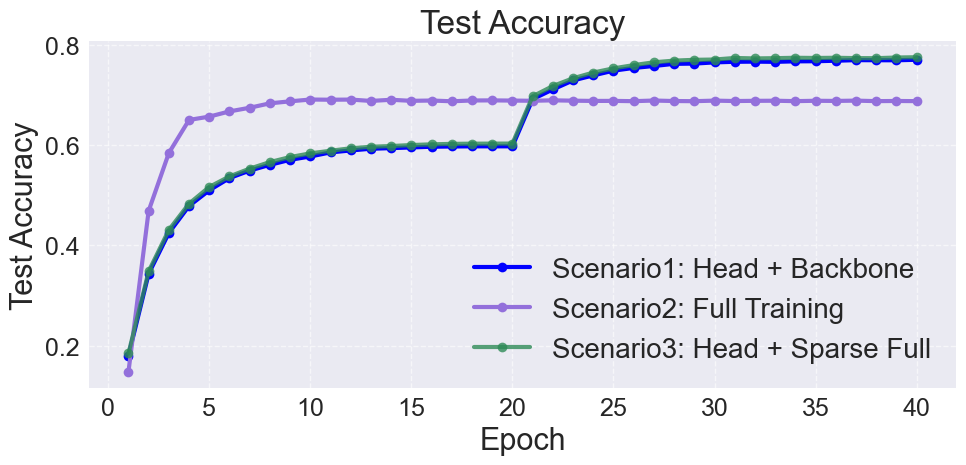

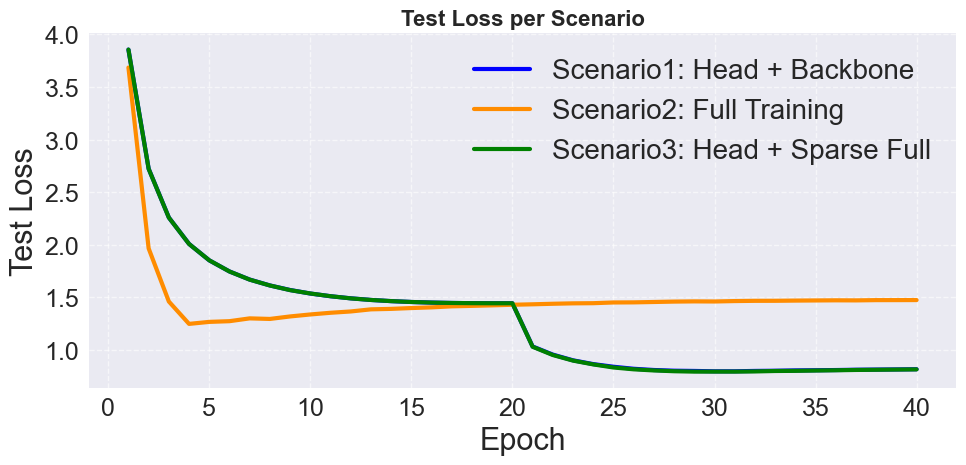

                     Scenario  Best Accuracy  Final Accuracy  Best Loss  \
0        Scenario1: Head-only         0.6026          0.6026   1.442544   
1  Scenario1: Backbone Sparse         0.7755          0.7754   0.795804   
2    Scenario2: Full Training         0.6910          0.6878   1.246695   
3        Scenario3: Head-only         0.6031          0.6031   1.442520   
4      Scenario3: Sparse Full         0.7758          0.7757   0.792757   

   Final Loss  Training Time (s)  
0    1.442544         516.179976  
1    0.820384        2011.213119  
2    1.473262        3246.309292  
3    1.442520         518.570146  
4    0.819275        2009.340265  


In [ ]:

# === Load Results ===
with open("results_three_scenarios.json", "r") as f:
    results_all = json.load(f)

# === Data Preparation ===
# Scenario 1: Head-only + Backbone Sparse
acc_s1_head = results_all['scenario1']['head_only']['test_accuracies']
acc_s1_backbone = results_all['scenario1']['backbone_sparse']['test_accuracies']
acc_s1_combined = acc_s1_head + acc_s1_backbone  # 20+30 ephocs

loss_s1_head = results_all['scenario1']['head_only']['test_losses']
loss_s1_backbone = results_all['scenario1']['backbone_sparse']['test_losses']
loss_s1_combined = loss_s1_head + loss_s1_backbone

# Scenario 2: Full Training
acc_s2 = results_all['scenario2_full']['test_accuracies']
loss_s2 = results_all['scenario2_full']['test_losses']

# Scenario 3: Head-only + Sparse Full
acc_s3_head = results_all['scenario3_sparse_full']['head_only']['test_accuracies']
acc_s3_sparse = results_all['scenario3_sparse_full']['sparse_full']['test_accuracies']
acc_s3_combined = acc_s3_head + acc_s3_sparse  # 20+30 epohcs

loss_s3_head = results_all['scenario3_sparse_full']['head_only']['test_losses']
loss_s3_sparse = results_all['scenario3_sparse_full']['sparse_full']['test_losses']
loss_s3_combined = loss_s3_head + loss_s3_sparse



# Number of epochs to cut
cut_last = 10

# === Accuracy ===
acc_s1_combined = acc_s1_combined[:-cut_last]
acc_s2 = acc_s2[:-cut_last]
acc_s3_combined = acc_s3_combined[:-cut_last]

# === Loss ===
loss_s1_combined = loss_s1_combined[:-cut_last]
loss_s2 = loss_s2[:-cut_last]
loss_s3_combined = loss_s3_combined[:-cut_last]



# === Plot Test Accuracy ===
plt.figure(figsize=(10,5))
plt.title("Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Test Accuracy")
plt.grid(True, linestyle='--', alpha=0.6)

offset = -0.005
plt.plot(range(1,len(acc_s1_combined)+1), [a+offset for a in acc_s1_combined], label='Scenario1: Head + Backbone', color='blue', marker='o')
plt.plot(range(1,len(acc_s2)+1), acc_s2, label='Scenario2: Full Training', color="mediumpurple", marker='o')
plt.plot(range(1,len(acc_s3_combined)+1), acc_s3_combined, label='Scenario3: Head + Sparse Full', color='seagreen', marker='o', alpha=0.8)

plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

# === Plot Test Loss ===
plt.figure(figsize=(10,5))
plt.title("Test Loss per Scenario", fontsize=16, fontweight='bold')
plt.xlabel("Epoch")
plt.ylabel("Test Loss")
plt.grid(True, linestyle='--', alpha=0.6)

plt.plot(range(1,len(loss_s1_combined)+1), loss_s1_combined, label='Scenario1: Head + Backbone', color='blue')
plt.plot(range(1,len(loss_s2)+1), loss_s2, label='Scenario2: Full Training', color='#FF8C00')
plt.plot(range(1,len(loss_s3_combined)+1), loss_s3_combined, label='Scenario3: Head + Sparse Full', color='green')

plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

# === Summary DataFrame ===
summary_data = [
    {
        'Scenario': 'Scenario1: Head-only',
        'Best Accuracy': max(acc_s1_head),
        #'Final Accuracy': acc_s1_head[-1],
        'Best Loss': min(loss_s1_head),
        #'Final Loss': loss_s1_head[-1],
        'Training Time (s)': results_all['scenario1']['head_only']['time_sec']
    },
    {
        'Scenario': 'Scenario1: Backbone Sparse',
        'Best Accuracy': max(acc_s1_backbone),
        #'Final Accuracy': acc_s1_backbone[-1],
        'Best Loss': min(loss_s1_backbone),
        #'Final Loss': loss_s1_backbone[-1],
        'Training Time (s)': results_all['scenario1']['backbone_sparse']['time_sec']
    },
    {
        'Scenario': 'Scenario2: Full Training',
        'Best Accuracy': max(acc_s2),
        #'Final Accuracy': acc_s2[-1],
        'Best Loss': min(loss_s2),
        #'Final Loss': loss_s2[-1],
        'Training Time (s)': results_all['scenario2_full']['time_sec']
    },
    {
        'Scenario': 'Scenario3: Head-only',
        'Best Accuracy': max(acc_s3_head),
        #'Final Accuracy': acc_s3_head[-1],
        'Best Loss': min(loss_s3_head),
        #'Final Loss': loss_s3_head[-1],
        'Training Time (s)': results_all['scenario3_sparse_full']['head_only']['time_sec']
    },
    {
        'Scenario': 'Scenario3: Sparse Full',
        'Best Accuracy': max(acc_s3_sparse),
        #'Final Accuracy': acc_s3_sparse[-1],
        'Best Loss': min(loss_s3_sparse),
        #'Final Loss': loss_s3_sparse[-1],
        'Training Time (s)': results_all['scenario3_sparse_full']['sparse_full']['time_sec']
    }
]

df_summary = pd.DataFrame(summary_data)
print(df_summary)


